In [1]:
import os
import scipy.io

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Configuration parameters
num_channels = 256
length_timebins = 159136

##### Load file

In [3]:
filepath = r"F:\RiceStudy\speechBCI\data\tuningTasks"
filename = "t12.2022.04.26_phonemes.mat"
matfile_path = os.path.join(filepath, filename)

tuning_data = scipy.io.loadmat(matfile_path)

##### Generate "phoneme - neural activty" chart

In [4]:
# Extract neural activity and phonemes records
## Phonemes are recorded in tuning_data['trailCues']

## extract indexes in records

gotrial_start = np.array(tuning_data['goTrialEpochs'][:, 0])
gotrial_end = np.array(tuning_data['goTrialEpochs'][:, 1])

C:\Users\Physail\AppData\Local\Temp\ipykernel_14768\3759261008.py:47: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  audio_phone.append(phonemes_chart[int(tuning_data['trialCues'][i]) - 1])


[100328, 100520, 100707, 100916, 101131, 101335, 101551, 101766, 101952, 102137, 102373]


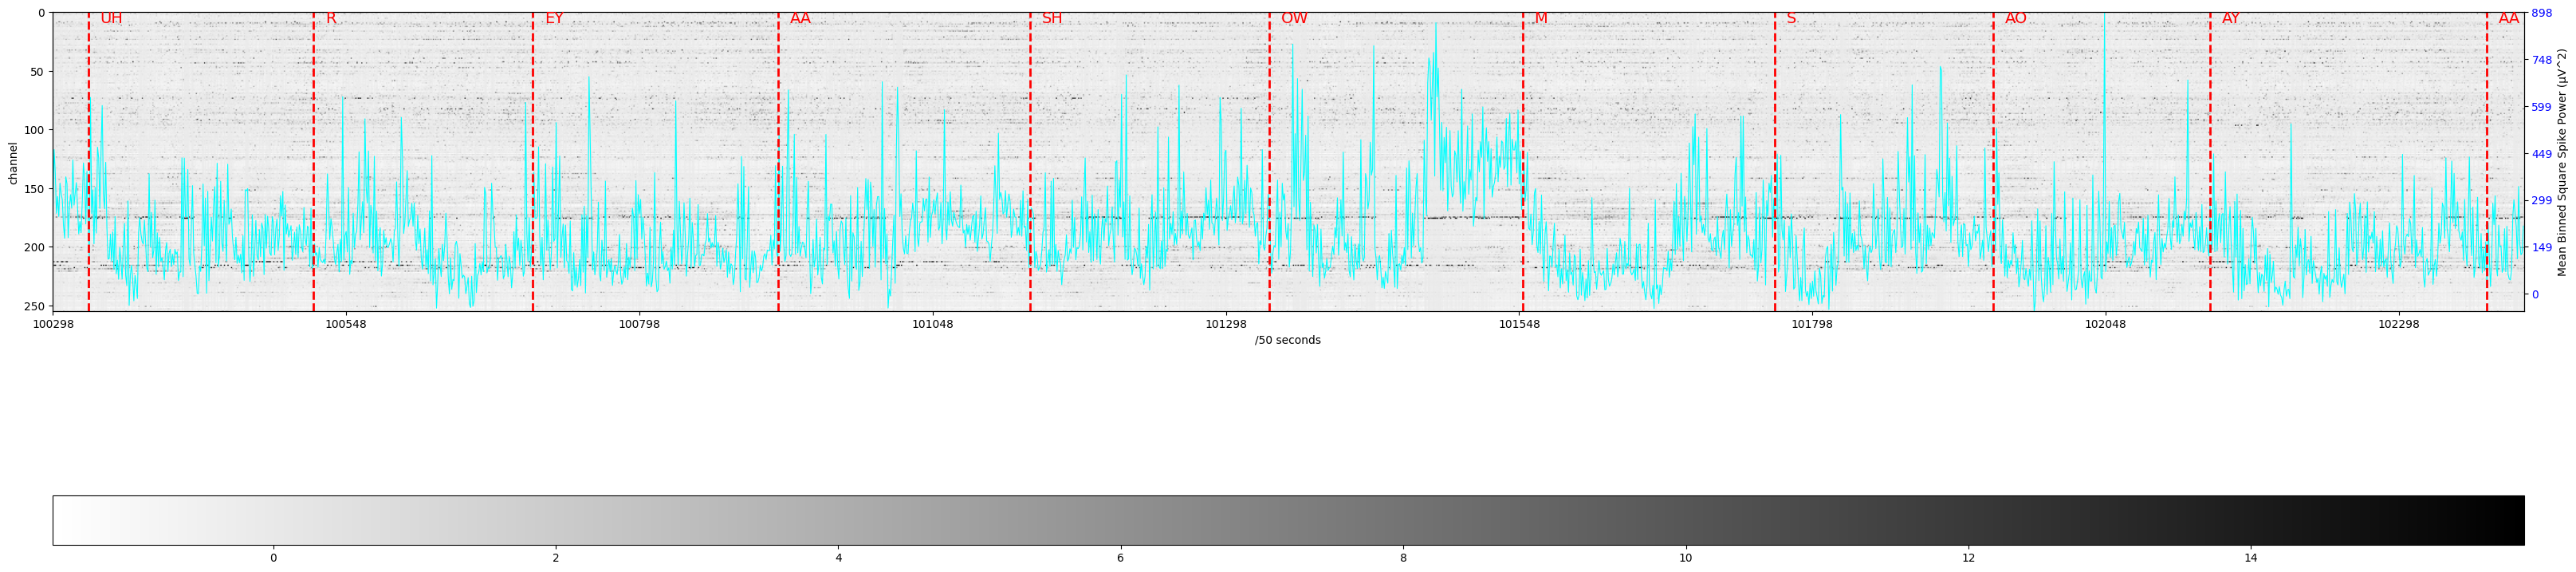

<Figure size 640x480 with 0 Axes>

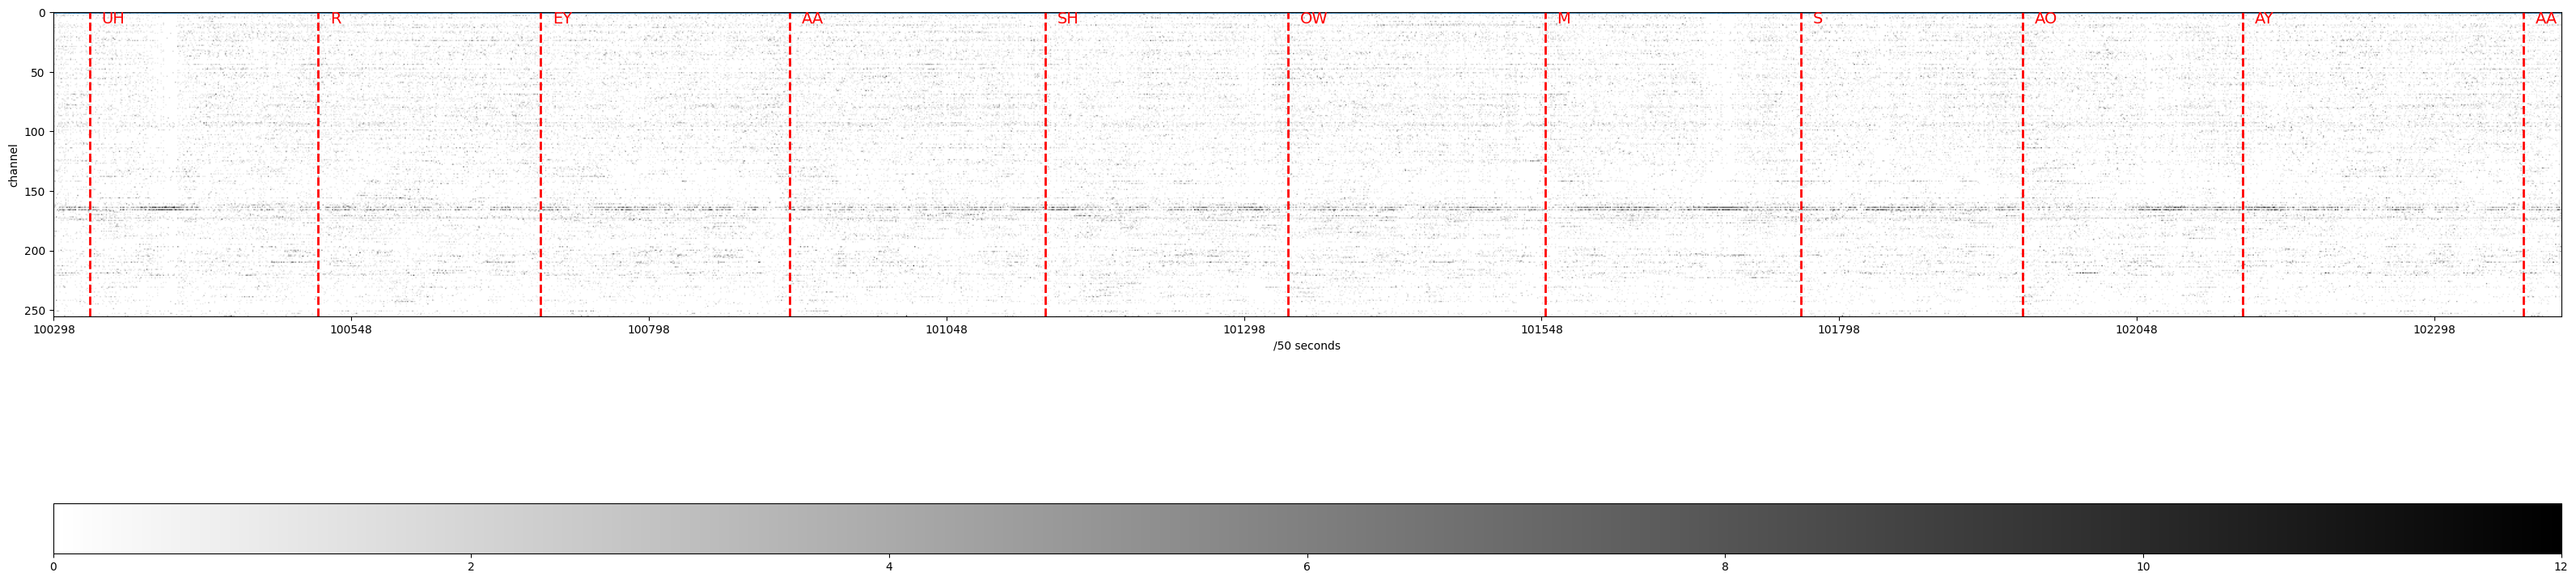

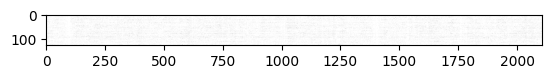

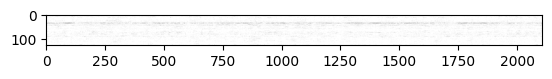

In [ ]:
phonemes_chart = ['B','CH','NOTHING','D','F','G','HH','JH','K','L','ER','M','N','NG','P','R','S','SH','DH','T','TH', 'V','W',\
    'Y','Z','ZH','OY','EH','EY','UH','IY','OW','UW','IH','AA','AW','AY','AH','AO','AE']

## extract and rearrange neural activities
### def Z-score. input an numpy array
def z_score(x):
    mean = np.mean(x)
    std = np.std(x)
    if std == 0:
        return 0
    return (x - mean) / std
### def subtraction mean. input an numpy array
def subt_mean(x):
    mean = np.mean(x)
    return x - mean

### def visualization function
def visuali_LFP_audio(starttrial, endtrial): # [starttrial, endtrial]
    startpoint = gotrial_start[starttrial]
    endpoint = gotrial_end[endtrial] + 1

    spikepow = tuning_data['spikePow'][startpoint : endpoint, :].copy()
    tx2 = tuning_data['tx2'][startpoint : endpoint, :].copy()

    #### rearrange data
    mean_spikepow = []
    mean_tx2 = []

    for i in range(np.shape(spikepow)[0]):
        mean = np.mean(spikepow[i])
        mean_spikepow.append(mean)
        spikepow[i] = z_score(spikepow[i].copy())
        mean = np.mean(tx2[i])
        mean_tx2.append(mean)
        tx2[i] = z_score(tx2[i].copy())
    

    #### get audio timestamp and the phoneme
    audio_times = []
    audio_phone = []

    for i in range(starttrial, endtrial + 1):
        window_left = max(gotrial_start[i] - 10, 0)
        window_right = min(gotrial_end[i] + 11, length_timebins)
        window_audios = np.array(tuning_data['audioEnvelope'][window_left : window_right])
        audio_times.append(np.argmax(window_audios) + window_left)
        audio_phone.append(phonemes_chart[int(tuning_data['trialCues'][i]) - 1])

#
    print(audio_times)


    #### plot (only try spikepower first)
    fig, ax1 = plt.subplots(figsize = (40, 30))
    im = ax1.imshow(spikepow.T, cmap = 'binary', vmin = np.min(spikepow), vmax = np.max(spikepow)) # plot each channel's z-score
    fig.colorbar(im, ax = ax1, orientation='horizontal', pad=0.1, aspect=50)
    ax1.set_ylim(num_channels - 1, 0)
    ax1.set_xlabel("/50 seconds")
    ax1.set_ylabel("channel")
    ax1.set_xticks(np.arange(0, endpoint - startpoint, 250))
    ax1.set_xticklabels(np.arange(startpoint, endpoint, 250))

    ##### plot mean value curve, and set mean value curve axis
    ax2min, ax2max = np.min(mean_spikepow), np.max(mean_spikepow)
    meanspikepow_scaled = num_channels - (mean_spikepow - ax2min) / (ax2max - ax2min) * num_channels
    ax1.plot(meanspikepow_scaled, color = 'cyan', linewidth=0.8) # plot mean neural activity at each timestep
    
    pos1 = ax1.get_position()
    ax2 = ax1.twinx()
    ax2.set_position(pos1)

    ax2.set_ylabel("Mean Binned Square Spike Power (\u03bcV^2)")
    ax2.set_ylim(num_channels - 1, 0)
    ax2.set_yticks(np.arange(0, num_channels - 1, 40))
    ax2label_val = np.linspace(ax2min, ax2max, len(np.arange(0, num_channels - 1, 40)))
    ax2label = [int(ax2max - i) for i in ax2label_val]
    ax2.set_yticklabels(ax2label)
    ax2.tick_params(axis = 'y', labelcolor = 'blue')
    for i in range(len(audio_times)): # plot the maximum time of audio
        t_index = audio_times[i] - startpoint
        plt.axvline(x = t_index, color='red', linestyle='--', linewidth=2)
        plt.text(t_index + 10, -1, audio_phone[i], color='red', fontsize=14, rotation=0, verticalalignment='top')
    plt.show()
    plt.clf()


    #### (try tx2 also)
    plt.figure(figsize = (40, 30))
    plt.imshow(tx2.T, cmap = 'binary', vmin = np.min(tx2), vmax = np.max(tx2)) # plot each channel's z-score
    plt.colorbar(orientation='horizontal', pad=0.1, aspect=50)
    plt.xlabel("/50 seconds")
    plt.ylabel("channel")
    plt.xticks(np.arange(0, endpoint - startpoint, 250), np.arange(startpoint, endpoint, 250))
    plt.plot(mean_tx2) # plot mean neural activity at each timestep
    for i in range(len(audio_times)): # plot the maximum time of audio
        t_index = audio_times[i] - startpoint
        plt.axvline(x = t_index, color='red', linestyle='--', linewidth=2)
        plt.text(t_index + 10, -1, audio_phone[i], color='red', fontsize=14, rotation=0, verticalalignment='top')
    plt.show()
    plt.clf()


visuali_LFP_audio(505, 515)

In [ ]:
## extract neural activity



neu2pho_spikepow_chart = np.zeros((len(phonemes_chart), num_channels))
neu2pho_tx_chart = np.zeros((len(phonemes_chart), num_channels))

pho_cuenum = np.zeros(len(phonemes_chart))

for i in range(len(gotrial_start)):
    sta_p = gotrial_start[i]
    end_p = gotrial_end[i]

    spike_pow_sample = all_spikepow[sta_p : end_p, :]
    tx_sample = all_tx2[sta_p : end_p, :]

    # spike_pow_mean = np.mean(spike_pow_sample, axis = 0)
    # tx_mean = np.mean(tx_sample, axis = 0)

    pho = tuning_data['trialCues'][i] - 1
    neu2pho_spikepow_chart[pho] += spike_pow_mean
    neu2pho_tx_chart[pho] += tx_mean
    pho_cuenum[pho] += 1

for i in range(len(phonemes_chart)):
    neu2pho_spikepow_chart[i] /= pho_cuenum[i]
    neu2pho_tx_chart[i] /= pho_cuenum[i]

baseline_sp = np.mean(neu2pho_spikepow_chart, axis = 0)
baseline_tx = np.mean(neu2pho_tx_chart, axis = 0)
for i in range(len(phonemes_chart)):
    neu2pho_spikepow_chart[i] -= baseline_sp
    neu2pho_tx_chart[i] -= baseline_tx



##### Raw data visualization

In [16]:
### 


##### Representational similarity

In [17]:
# def of cross product calculation
def cross_product(x, y):
    if len(x) != len(y):
        return 0
    
    t = 0
    for i in range(len(x)):
        t += x[i] * y[i]

    return t


# def of representation similarity calculation
def repre_similarity(x, y):
    if cross_product(x, x) == 0 or cross_product(y, y) == 0:
        return 0
    if len(x) != len(y):
        return 0
    
    t = 0
    return cross_product(x, y) / np.sqrt(cross_product(x, x)) / np.sqrt(cross_product(y, y))

In [18]:
# Plot representational similarity
map_similarity = np.zeros((len(phonemes_chart), len(phonemes_chart)))

consonant_clusteredchart = ['P', 'B', 'M', 'F', 'V', 'TH', 'DH', 'T', 'D', 'N', 'S', 'Z', 'CH', 'JH', 'SH', 'ZH', 'NG', 'K', 'G', 'Y', 'L', 'R', 'W']
vowel_clusteredchart = ['OY', 'OW', 'AO', 'AA', 'AW', 'AY', 'AE', 'EH', 'EY', 'IY', 'IH', 'AH', 'UW', 'ER', 'UH']

phoneme_clusteredchart = np.append(consonant_clusteredchart[:], vowel_clusteredchart[:])

## generate shuffle map for the arrays according to phoneme clustering
shuffle_map = [0] * len(phoneme_clusteredchart)
for i in range(len(shuffle_map)):
    shuffleindex = phonemes_chart.index(phoneme_clusteredchart[i])
    shuffle_map[i] = int(shuffleindex)

In [19]:
## calculate similarity
similarity_sp = np.zeros((len(shuffle_map), len(shuffle_map)))
similarity_tx = np.zeros((len(shuffle_map), len(shuffle_map)))

for i in range(len(shuffle_map)):
    for j in range(i, len(shuffle_map)):
        similarity_sp[i, j] = repre_similarity(neu2pho_spikepow_chart[i, :], neu2pho_spikepow_chart[j, :])
        similarity_tx[i, j] = repre_similarity(neu2pho_tx_chart[i, :], neu2pho_tx_chart[j, :])
        similarity_sp[j, i] = similarity_sp[i, j]
        similarity_tx[j, i] = similarity_tx[i, j]

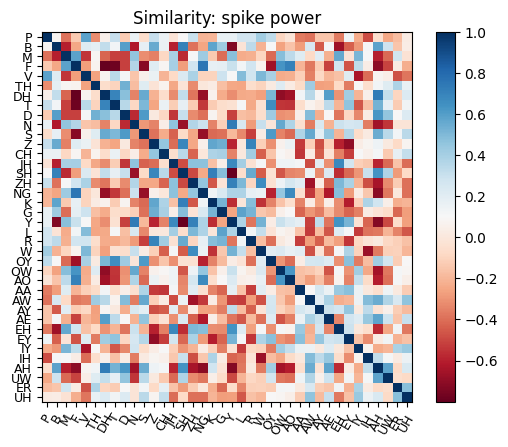

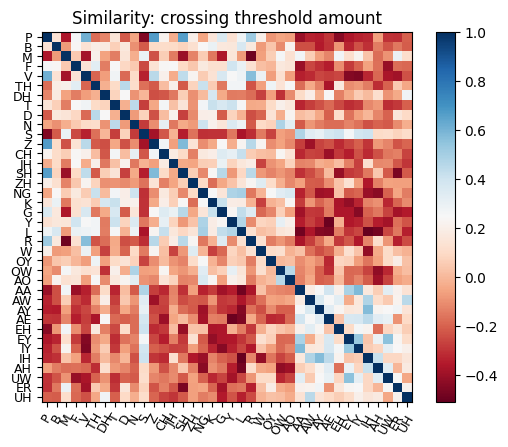

<Figure size 640x480 with 0 Axes>

In [20]:
## plot similarity
plt.imshow(similarity_sp, cmap='RdBu')
plt.title("Similarity: spike power")
plt.colorbar()
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.show()

plt.clf()

plt.imshow(similarity_tx, cmap='RdBu')
plt.title("Similarity: crossing threshold amount")
plt.xticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9, rotation=60)
plt.yticks(ticks=np.arange(len(phoneme_clusteredchart)), labels=phoneme_clusteredchart, fontsize = 9)
plt.colorbar()
plt.show()

plt.clf()

##### Clustering 2022.04.26

##### Debug Zone

In [ ]:
print(tuning_data['spikePow'][gotrial_start[45] : gotrial_end[55], :])
print(tuning_data['spikePow'][startpoint : endpoint, :])

[[ 232.90376  596.8363  1122.2817  ...  510.52066  666.32446  512.4101 ]
 [ 229.06473 1374.9751   916.9631  ...  343.11414  360.94183  554.9325 ]
 [ 225.19287  596.534    482.34155 ...  485.13022  407.57135  943.1722 ]
 ...
 [ 198.73022 1133.6019  2769.2449  ...  430.14664  670.24164  995.1246 ]
 [ 213.88806  515.8043   599.1883  ...  821.18616  612.7708   727.00854]
 [ 193.3026   743.4267   350.25656 ...  624.9888   523.40814  887.94525]]
